# K-Nearest Neighbours (KNN) on a Custom Synthetic Dataset

This notebook walks through a complete KNN workflow on a **hand-crafted synthetic classification dataset**.  
We will:

- Build a 3-class, 4-feature dataset with some deliberately tricky properties (different scales, noisy features).
- Visualise the data in 2D.
- Train and evaluate KNN models with and without feature scaling.
- Use cross-validation to choose the best value of **k**.
- Explore how adding noisy dimensions can hurt KNN performance (the *curse of dimensionality*).


## 1. Imports and basic setup

We start by importing:

- **NumPy** and **Pandas** for data manipulation.
- **Matplotlib** for plotting.
- Scikit-learn utilities for:
  - Splitting train/test sets
  - Scaling features (`StandardScaler`)
  - Building pipelines (`Pipeline`)
  - Training a KNN classifier (`KNeighborsClassifier`)
  - Evaluating performance (accuracy, classification report, confusion matrix).

We also set a random seed to make results reproducible and tweak some plotting defaults.


In [1]:
# Custom synthetic dataset + KNN experiments

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 11

np.random.seed(42)

print("Imports done.")


Imports done.


## 2. Generate a custom synthetic dataset

Here we define a helper function `generate_custom_knn_dataset` that:

1. Creates three Gaussian blobs in a 2D space (`x1`, `x2`), one per class.
2. Adds two extra features:
   - A **big_scale_feature** with values on a much larger numeric scale.
   - A **noise_feature** that does not contain useful signal.
3. Combines everything into a Pandas `DataFrame` with columns:
   - `x1`, `x2`, `big_scale_feature`, `noise_feature`, and the target `class`.

Finally, we generate the dataset with `n_per_class=300`, print its shape, and display the first few rows.


In [ ]:
# Create custom synthetic dataset

def generate_custom_knn_dataset(
    n_per_class=300,
    random_state=42
):
    rng = np.random.RandomState(random_state)

    # 2D "core" features for three classes (Gaussian blobs)
    means = np.array([
        [0.0, 0.0],    # Class 0
        [2.5, 2.0],    # Class 1
        [0.0, 3.0]     # Class 2
    ])

    cov = np.array([
        [[0.4, 0.0], [0.0, 0.4]],
        [[0.5, 0.2], [0.2, 0.5]],
        [[0.3, -0.1], [-0.1, 0.3]]
    ])

    X_list = []
    y_list = []

    for class_idx in range(3):
        X_class = rng.multivariate_normal(
            mean=means[class_idx],
            cov=cov[class_idx],
            size=n_per_class
        )
        y_class = np.full(n_per_class, class_idx)
        X_list.append(X_class)
        y_list.append(y_class)

    X_core = np.vstack(X_list)   # shape (3*n_per_class, 2)
    y = np.concatenate(y_list)   # shape (3*n_per_class,)

    # Additional features to highlight scaling effects
    # Feature 3: large scale (roughly 100x bigger than x1)
    f3 = 50 * X_core[:, 0] + rng.normal(scale=5.0, size=X_core.shape[0])

    # Feature 4: mostly noise, different scale again
    f4 = rng.normal(loc=0.0, scale=100.0, size=X_core.shape[0])

    # Full feature matrix
    X_full = np.column_stack([X_core[:, 0], X_core[:, 1], f3, f4])

    columns = ["x1", "x2", "big_scale_feature", "noise_feature"]
    df = pd.DataFrame(X_full, columns=columns)
    df["class"] = y

    return df

df = generate_custom_knn_dataset(n_per_class=300)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (900, 5)


,x1,x2,big_scale_feature,noise_feature,class
0,0.314150,-0.087446,25.213434,38.680852,0
1,0.409634,0.963249,20.178406,109.098043,0
2,-0.148092,-0.148081,-10.946614,201.227045,0
3,0.998782,0.485368,42.370522,102.370955,0
4,-0.296922,0.343145,-23.861782,24.930860,0


## 3. Visualise the 2D core features (`x1`, `x2`)

Before we train any models, it’s useful to see what the data looks like.

This cell:

- Plots `x1` vs `x2` for all points.
- Uses different colours/markers for each of the three classes.
- Adds axis labels, a title, and a legend.

This gives us a geometric intuition for how separable the classes are in the original 2D space.


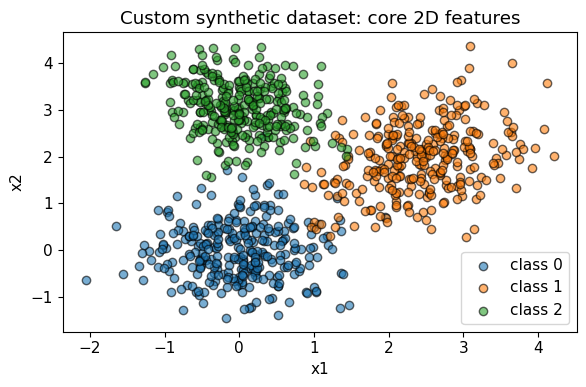

In [ ]:
# Visualisation of the 2D core features (x1, x2)

plt.figure()
for cls in sorted(df["class"].unique()):
    subset = df[df["class"] == cls]
    plt.scatter(subset["x1"], subset["x2"], label=f"class {cls}", alpha=0.6, edgecolor="k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Custom synthetic dataset: core 2D features")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Split into train and test sets

Next, we:

- Build a feature matrix `X` using all four features:
  - `x1`, `x2`, `big_scale_feature`, `noise_feature`
- Set the target vector `y` to be the `class` column.
- Use `train_test_split` to split the data into training and test sets.

We also print the shapes of the resulting arrays and the class distribution to check that the split looks sensible.


In [ ]:
# Split into train and test sets

X = df[["x1", "x2", "big_scale_feature", "noise_feature"]].values
y = df["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Class distribution in y:", np.bincount(y))


X_train shape: (630, 4)
X_test shape: (270, 4)
Class distribution in y: [300 300 300]


## 5. Helper function to plot 2D decision boundaries

KNN is a geometric algorithm, so decision boundaries are very informative.

This cell defines a utility function that:

- Takes a trained 2D KNN model (using `x1` and `x2` only).
- Creates a fine grid over the feature space.
- Uses the model to predict the class at each grid point.
- Uses a contour plot plus scatter points to visualise:
  - The decision regions (background colours).
  - The actual data points for each class.

We will reuse this helper to compare the effect of different values of **k**.


In [ ]:
# Helper to plot decision boundary for 2D features (x1, x2)
# using only the first two columns of X

def plot_decision_boundary_2d(model, X_2d, y, title="Decision boundary (2D)"):
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", alpha=0.7)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.tight_layout()
    plt.show()


## 6. Decision boundaries for different values of *k* (2D only)

Here we focus just on the 2D features (`x1`, `x2`) and train KNN models with different `k` values, e.g.:

- `k = 1` (very flexible, can overfit)
- `k = 5` (moderate smoothing)
- `k = 15` (more smoothing, can underfit)

For each value of `k` we:

1. Fit a KNN classifier on the 2D features.
2. Plot the decision boundary using the helper function from the previous cell.

This illustrates visually how changing `k` affects the complexity of the decision regions.


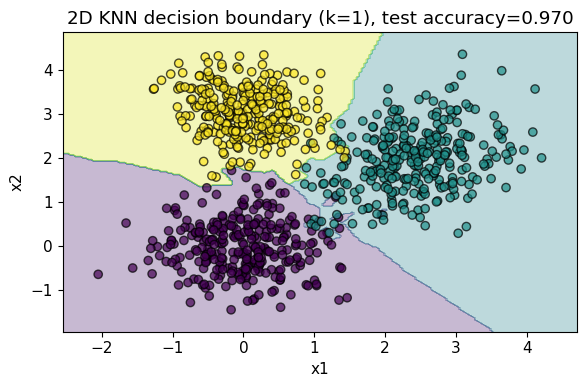

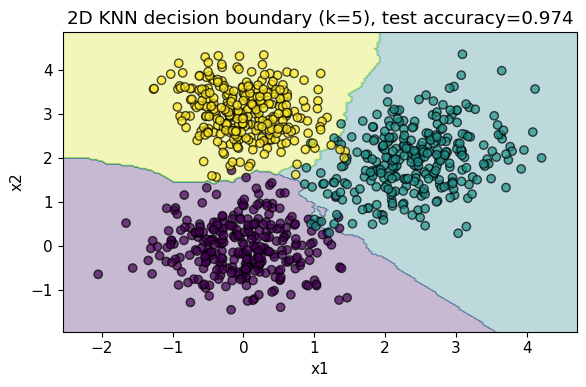

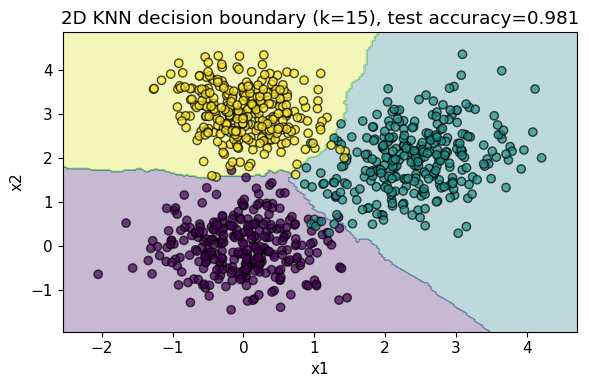

In [ ]:
# Decision boundaries for different k (2D core features only)

X2 = df[["x1", "x2"]].values
y_all = df["class"].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all
)

for k in [1, 5, 15]:
    knn_2d = KNeighborsClassifier(n_neighbors=k)
    knn_2d.fit(X2_train, y2_train)

    y2_pred = knn_2d.predict(X2_test)
    acc2 = accuracy_score(y2_test, y2_pred)

    title = f"2D KNN decision boundary (k={k}), test accuracy={acc2:.3f}"
    plot_decision_boundary_2d(knn_2d, X2, y_all, title=title)


## 7. KNN on the full 4D dataset **without** scaling

Now we move to the full feature set with 4 dimensions:

- `x1`, `x2`, `big_scale_feature`, `noise_feature`

In this cell we:

- Train a `KNeighborsClassifier` directly on the raw features.
- Generate predictions on the test set.
- Compute:
  - Overall accuracy on the test set.
  - A detailed classification report (precision, recall, F1 per class).
  - A confusion matrix, displayed as a small table.

Because one feature has a much larger numeric range, KNN may be **dominated** by that feature’s scale, which can hurt performance.


In [ ]:
# KNN on full 4D dataset WITHOUT scaling

knn_no_scale = KNeighborsClassifier(n_neighbors=5)
knn_no_scale.fit(X_train, y_train)

y_pred_no_scale = knn_no_scale.predict(X_test)

acc_no_scale = accuracy_score(y_test, y_pred_no_scale)
print(f"Test accuracy WITHOUT scaling (k=5): {acc_no_scale:.3f}")

print("\nClassification report (NO scaling):")
print(classification_report(y_test, y_pred_no_scale))

cm_no_scale = confusion_matrix(y_test, y_pred_no_scale)
cm_no_scale_df = pd.DataFrame(
    cm_no_scale,
    index=[f"True_{c}" for c in np.unique(y)],
    columns=[f"Pred_{c}" for c in np.unique(y)]
)
print("\nConfusion matrix (NO scaling):")
display(cm_no_scale_df)


Test accuracy WITHOUT scaling (k=5): 0.644

Classification report (NO scaling):
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        90
           1       0.92      0.93      0.93        90
           2       0.51      0.53      0.52        90

    accuracy                           0.64       270
   macro avg       0.64      0.64      0.64       270
weighted avg       0.64      0.64      0.64       270


Confusion matrix (NO scaling):


,Pred_0,Pred_1,Pred_2
True_0,42,5,43
True_1,3,84,3
True_2,40,2,48


## 8. KNN on the full dataset **with feature scaling**

To fix the scale issue, we build a **pipeline** that:

1. Applies `StandardScaler` to standardise each feature (zero mean, unit variance).
2. Trains a `KNeighborsClassifier` on the scaled features.

We then:

- Fit this pipeline on the training data.
- Evaluate it on the test set (accuracy, classification report, confusion matrix).

Comparing these metrics with the previous cell shows the benefit of scaling for distance-based models like KNN.


In [ ]:
# KNN on full dataset WITH scaling

knn_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_scaled.fit(X_train, y_train)

y_pred_scaled = knn_scaled.predict(X_test)

acc_scaled = accuracy_score(y_test, y_pred_scaled)
print(f"Test accuracy WITH scaling (k=5): {acc_scaled:.3f}")

print("\nClassification report (WITH scaling):")
print(classification_report(y_test, y_pred_scaled))

cm_scaled = confusion_matrix(y_test, y_pred_scaled)
cm_scaled_df = pd.DataFrame(
    cm_scaled,
    index=[f"True_{c}" for c in np.unique(y)],
    columns=[f"Pred_{c}" for c in np.unique(y)]
)
print("\nConfusion matrix (WITH scaling):")
display(cm_scaled_df)


Test accuracy WITH scaling (k=5): 0.981

Classification report (WITH scaling):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.97      0.98      0.97        90
           2       0.98      0.97      0.97        90

    accuracy                           0.98       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.98      0.98      0.98       270


Confusion matrix (WITH scaling):


,Pred_0,Pred_1,Pred_2
True_0,90,0,0
True_1,0,88,2
True_2,0,3,87


## 9. Compare accuracies with and without scaling

This cell creates a simple bar chart with two bars:

- Accuracy **without** scaling.
- Accuracy **with** scaling.

It also prints the numerical values for both accuracies.

This makes it easy to see how much performance we gained by adding the scaling step.


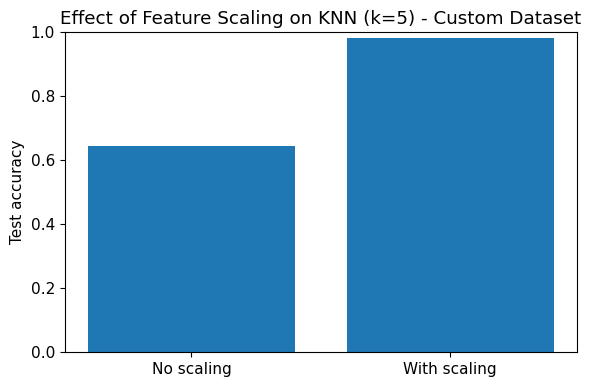

Accuracy without scaling: 0.644
Accuracy with scaling:    0.981


In [ ]:
# Compare accuracies visually

plt.figure()
plt.bar(["No scaling", "With scaling"], [acc_no_scale, acc_scaled])
plt.ylim(0, 1)
plt.ylabel("Test accuracy")
plt.title("Effect of Feature Scaling on KNN (k=5) - Custom Dataset")
plt.tight_layout()
plt.show()

print(f"Accuracy without scaling: {acc_no_scale:.3f}")
print(f"Accuracy with scaling:    {acc_scaled:.3f}")


## 10. Cross-validation over different values of *k* (with scaling)

We now tune the hyperparameter **k** using cross-validation:

- Define a range of `k` values (e.g. `1` to `30`).
- For each `k`, build a pipeline: `StandardScaler` → `KNeighborsClassifier(n_neighbors=k)`.
- Use `cross_val_score` with K-fold CV to estimate the mean accuracy for that `k`.
- Store the mean scores and plot them against `k`.

Finally, we identify the `k` that produces the **best mean CV accuracy**, which will be used as our final model setting.


Best k from CV: 9 with mean accuracy 0.981


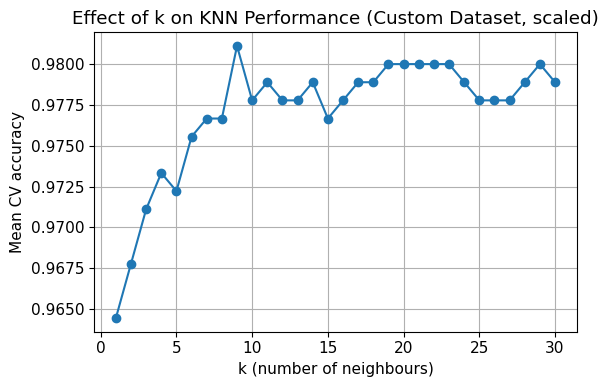

In [ ]:
# Cross-validation over k = 1..30 WITH scaling

k_values = range(1, 31)
mean_cv_scores = []

for k in k_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(model, X, y, cv=5)
    mean_cv_scores.append(scores.mean())

best_index = int(np.argmax(mean_cv_scores))
best_k = list(k_values)[best_index]
best_score = mean_cv_scores[best_index]

print(f"Best k from CV: {best_k} with mean accuracy {best_score:.3f}")

plt.figure()
plt.plot(list(k_values), mean_cv_scores, marker="o")
plt.xlabel("k (number of neighbours)")
plt.ylabel("Mean CV accuracy")
plt.title("Effect of k on KNN Performance (Custom Dataset, scaled)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 11. Train and evaluate the final KNN model

Using the best `k` found via cross-validation, we:

1. Build a final pipeline with `StandardScaler` and `KNeighborsClassifier(best_k)`.
2. Fit it on the **training** data.
3. Evaluate on the **test** data:
   - Test accuracy.
   - Classification report.
   - Confusion matrix (displayed as a labelled table).

This gives us an honest estimate of how well the tuned KNN model performs on unseen data.


In [ ]:
# Train final model with best k and scaling

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

acc_final = accuracy_score(y_test, y_pred_final)
print(f"Final test accuracy (k={best_k}): {acc_final:.3f}")

print("\nFinal classification report:")
print(classification_report(y_test, y_pred_final))

cm_final = confusion_matrix(y_test, y_pred_final)
cm_final_df = pd.DataFrame(
    cm_final,
    index=[f"True_{c}" for c in np.unique(y)],
    columns=[f"Pred_{c}" for c in np.unique(y)]
)
print("\nFinal confusion matrix:")
display(cm_final_df)


Final test accuracy (k=9): 0.978

Final classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.97      0.97      0.97        90
           2       0.98      0.97      0.97        90

    accuracy                           0.98       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.98      0.98      0.98       270


Final confusion matrix:


,Pred_0,Pred_1,Pred_2
True_0,90,0,0
True_1,1,87,2
True_2,0,3,87


## 12. Optional: illustrating the *curse of dimensionality*

KNN relies on distances between data points. In high dimensions, distances become less informative, and performance can degrade.

In this optional experiment we:

- Define a helper `add_noise_features` that appends extra random features to `X`.
- For a range of noise dimensions (e.g. 0, 2, 4, 8, ...):
  - Add that many purely random features to the original dataset.
  - Perform cross-validation with a fixed KNN setup.
  - Record the mean CV accuracy.

We then plot **mean CV accuracy vs number of added noise features**, showing how performance tends to drop as we add more irrelevant dimensions.


Noise dims:  0, CV accuracy: 0.981
Noise dims:  5, CV accuracy: 0.962
Noise dims: 20, CV accuracy: 0.917
Noise dims: 50, CV accuracy: 0.800


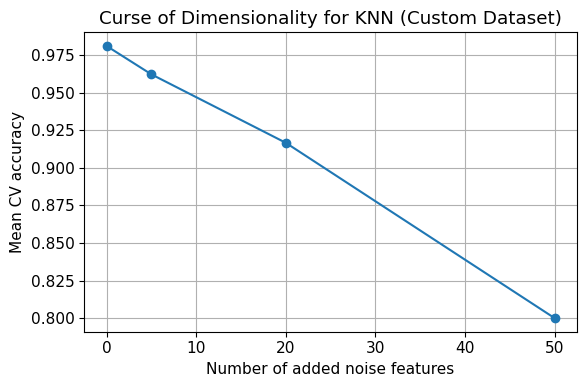

In [ ]:
# Optional: curse of dimensionality illustration

def add_noise_features(X, n_noise_features, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    noise = rng.normal(size=(n_samples, n_noise_features))
    return np.hstack([X, noise])

noise_dims = [0, 5, 20, 50]
cv_scores_noise = []

for n_noise in noise_dims:
    X_aug = add_noise_features(X, n_noise)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=best_k))
    ])
    scores = cross_val_score(model, X_aug, y, cv=5)
    cv_scores_noise.append(scores.mean())
    print(f"Noise dims: {n_noise:2d}, CV accuracy: {scores.mean():.3f}")

plt.figure()
plt.plot(noise_dims, cv_scores_noise, marker="o")
plt.xlabel("Number of added noise features")
plt.ylabel("Mean CV accuracy")
plt.title("Curse of Dimensionality for KNN (Custom Dataset)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 13. Wrap-up and key takeaways

The final cell prints a concise summary of everything we have done:

- How the custom dataset was generated.
- What the 2D decision boundaries look like for different values of *k*.
- How feature scaling improved KNN performance.
- The best `k` found via cross-validation and the corresponding accuracy.
- The effect of adding noisy high-dimensional features (curse of dimensionality).

You can run through the notebook step by step to reinforce your understanding of:

- How to **build and inspect** a synthetic dataset.
- How to **train, tune, and evaluate** KNN classifiers using scikit-learn.
- Why **scaling** and **dimensionality** matter so much for distance-based models.


In [ ]:
# Summary

print("Summary of custom KNN experiments:")
print(f"- Custom dataset with 3 Gaussian classes and 4 features was generated.")
print(f"- Decision boundaries in 2D (x1, x2) illustrate effect of k (1, 5, 15).")
print(f"- Scaling improved accuracy from {acc_no_scale:.3f} to {acc_scaled:.3f} for k=5.")
print(f"- Cross-validation found best k = {best_k} with mean accuracy {best_score:.3f}.")
print(f"- Final test accuracy with best k and scaling: {acc_final:.3f}.")
print("Optional noise-feature experiment shows performance drops as dimensionality/noise increases.")
print("Notebook finished.")


Summary of custom KNN experiments:
- Custom dataset with 3 Gaussian classes and 4 features was generated.
- Decision boundaries in 2D (x1, x2) illustrate effect of k (1, 5, 15).
- Scaling improved accuracy from 0.644 to 0.981 for k=5.
- Cross-validation found best k = 9 with mean accuracy 0.981.
- Final test accuracy with best k and scaling: 0.978.
Optional noise-feature experiment shows performance drops as dimensionality/noise increases.
Notebook finished.
